## 1. Import libraries and datasets

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

dataset = pd.read_csv('Churn_Modelling.csv')
# CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary
x = dataset.iloc[:, 3:-1].values
y = dataset.iloc[:, -1].values

## 2. Encode Categorical data

Label Encode the "Gender" column and One Hot Encode the "Geography" column

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Gender encode
le = LabelEncoder()
x[:, 2] = le.fit_transform(x[:, 2])

# Geography column encode
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
# Geography (3), CreditScore, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary
x = np.array(ct.fit_transform(x))

## 3. Preparing the dataset into the Training set and Test set

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

## 4a. Train using Logistic Regression

This is akin to a single "Neuron".

Credits: [@kanncaa1](https://www.kaggle.com/kanncaa1/deep-learning-tutorial-for-beginners)

<img src="https://sebastianraschka.com/images/faq/logisticregr-neuralnet/schematic.png" width="400" height="auto"/>

(Source: [Sebastian Raschka, n.d.](https://sebastianraschka.com/faq/docs/logisticregr-neuralnet.html))

In [177]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def euclidean_normalize(z, axis=0):
    return np.apply_along_axis(lambda a: np.sqrt(np.sum(np.power(a, 2))), axis, z)

class LogisticRegression:
    
    def __init__(self, x_dimension):
        self.weights = np.full((x_dimension), 0.01)
        self.bias = 0.0
        
    def activation_function(self, x_values):
        return sigmoid(np.dot(x_values, self.weights.T) + self.bias)

    def forward_propagation(self, x_values, y_values):
        # Use sigmoid activation function: Probabilistic value from 0-1
        y_computed = self.activation_function(x_values)
        # Use binary cross-entropy loss
        cost = np.sum(-y_values * np.log(y_computed) - (1 - y_values) * np.log(1 - y_computed)) / x_values.shape[1]        
        return y_computed, cost

    def backward_propagation(self, x_values, y_values, y_computed):
        y_derivative = y_computed - y_values
        # Apply linear combination (partial without sum) for each gradient * x input value
        x_values_gradient = np.array([x_values[i] * y_derivative[i] for i in range(x_values.shape[0])])
        # Sum all x input values which eventually divides by total rows
        x_values_hlc = np.array([np.sum(x_values_gradient[:,i]) for i in range(x_values_gradient.shape[1])]) / x_values.shape[0]

        # Derivative value of loss function with respect to weight
        weight_derivative = x_values_hlc / x_values.shape[1]

        # Derivative value of loss function with respect 
        bias_derivative = np.sum(y_derivative) / x_values.shape[1]
        return (weight_derivative, bias_derivative)

    def update_parameters(self, x_values, y_values, learning_rate=0.01, no_of_iterations=150):
        costs = []

        for i in range(no_of_iterations):
            y_computed, cost = self.forward_propagation(x_values, y_values)
            gradients = self.backward_propagation(x_values, y_values, y_computed)

            # Update weights and biases using gradient descent
            self.weights = self.weights - learning_rate * gradients[0]
            self.bias = self.bias - learning_rate * gradients[1]

            print(f'Cost for iteration {i + 1}: {cost}')
            costs.append(cost)

        return gradients, costs

    def predict(self, x_values):
        return np.array([self.activation_function([v]) for v in x_values])

model = LogisticRegression(x_train.shape[1])
_, costs = model.update_parameters(x_train, y_train)


Cost for iteration 1: 462.02618008671925
Cost for iteration 2: 355.0074026794641
Cost for iteration 3: 337.3645327392285
Cost for iteration 4: 337.1210814836616
Cost for iteration 5: 337.1042072379421
Cost for iteration 6: 337.0882018876999
Cost for iteration 7: 337.07220829303134
Cost for iteration 8: 337.0562204483935
Cost for iteration 9: 337.04023831111687
Cost for iteration 10: 337.02426187889915
Cost for iteration 11: 337.00829114971447
Cost for iteration 12: 336.9923261215391
Cost for iteration 13: 336.9763667923499
Cost for iteration 14: 336.9604131601241
Cost for iteration 15: 336.9444652228396
Cost for iteration 16: 336.9285229784746
Cost for iteration 17: 336.9125864250079
Cost for iteration 18: 336.8966555604188
Cost for iteration 19: 336.88073038268703
Cost for iteration 20: 336.86481088979286
Cost for iteration 21: 336.848897079717
Cost for iteration 22: 336.83298895044067
Cost for iteration 23: 336.8170864999456
Cost for iteration 24: 336.801189726214
Cost for iteration 

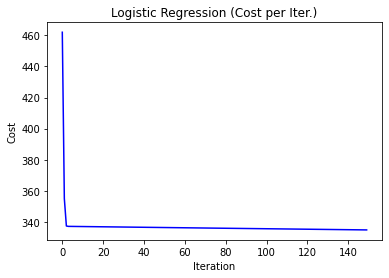

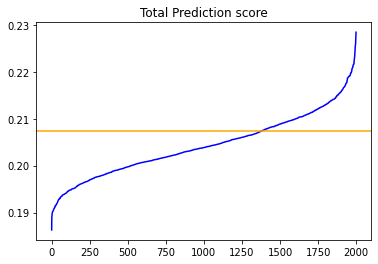

Divider:  0.20737770558167684


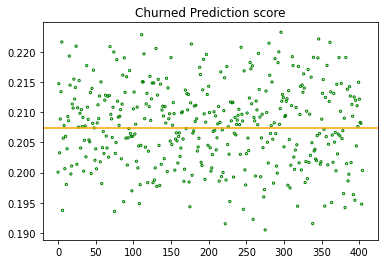

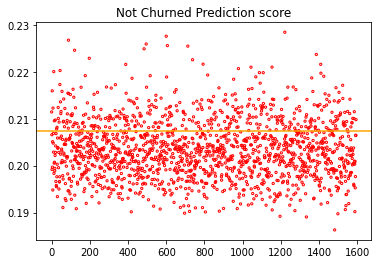

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


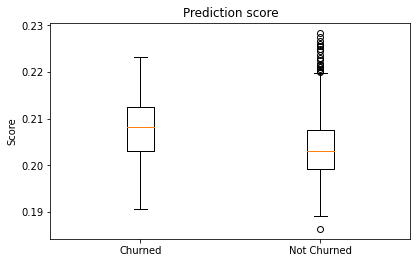


                    Churned  Not Churned
Outlier (min)     0.000000     0.186289
Outlier (max)     0.000000     0.228466
Outlier (avg)     0.000000     0.221650
Min               0.190499     0.189054
Max               0.223233     0.219845
Q1 (25%)          0.203031     0.199163
Q2 (50%, median)  0.208142     0.203101
Q3 (75%)          0.212445     0.207483 

             Pred. Not Churned  Pred. Churned
Not Churned               1193            402
Churned                    186            219 

Accuracy score: 0.706 (Correct: 1412, Incorrect: 588)

Total Churned: 405, Not Churned: 1595


In [178]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

plt.plot(np.arange(len(costs)), costs, color='blue')
plt.title('Logistic Regression (Cost per Iter.)')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

y_pred = model.predict(x_test)
y_pred_divider = (np.min(y_pred) + np.max(y_pred)) / 2

y_test_1 = list(map(lambda a: a[1], filter(lambda a: y_test[a[0]] == 1, enumerate(y_pred))))
y_test_0 = list(map(lambda a: a[1], filter(lambda a: y_test[a[0]] == 0, enumerate(y_pred))))

plt.plot(np.arange(len(y_pred)), sorted(y_pred), color='blue')
plt.axhline(y=y_pred_divider, color='orange', linestyle='-')
plt.title('Total Prediction score')
plt.show()

print('Divider: ', y_pred_divider)

plt.scatter(np.arange(len(y_test_1)), y_test_1, facecolors='none', edgecolors='green', s=5)
plt.axhline(y=y_pred_divider, color='orange', linestyle='-')
plt.title('Churned Prediction score')
plt.show()

plt.scatter(np.arange(len(y_test_0)), y_test_0, facecolors='none', edgecolors='red', s=5)
plt.axhline(y=y_pred_divider, color='orange', linestyle='-')
plt.title('Not Churned Prediction score')
plt.show()

fig = plt.figure(figsize =(5, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_ylabel('Score')
ax.set_title('Prediction score')
ax.set_xticklabels(('Churned', 'Not Churned'))
bp = ax.boxplot([
    [p[0] for i, p in enumerate(y_pred) if y_test[i] == 1],
    [p[0] for i, p in enumerate(y_pred) if y_test[i] == 0], 
])
plt.show()

outliers = [flier.get_ydata() for flier in bp['fliers']]
medians = [median.get_ydata() for median in bp['medians']]
whiskers = [whiskers.get_ydata() for whiskers in bp['whiskers']]

print('\n', pd.DataFrame([
    list(map(lambda i: np.min(outliers[i]) if np.sum(outliers[i]) > 1 else 0, [0,1])),
    list(map(lambda i: np.max(outliers[i]) if np.sum(outliers[i]) > 1 else 0, [0,1])),
    list(map(lambda i: np.average(outliers[i]) if np.sum(outliers[i]) > 1 else 0, [0,1])),
    [whiskers[0][1], whiskers[2][1]],
    [whiskers[1][1], whiskers[3][1]],
    [whiskers[0][0], whiskers[2][0]],
    [medians[0][0], medians[1][0]],
    [whiskers[1][0], whiskers[3][0]]
], columns=['Churned', 'Not Churned'], index=['Outlier (min)', 'Outlier (max)', 'Outlier (avg)', 'Min', 'Max', 'Q1 (25%)', 'Q2 (50%, median)', 'Q3 (75%)']), '\n')


y_pred = y_pred > y_pred_divider

cm = confusion_matrix(y_test, y_pred)

print(pd.DataFrame(cm, columns=['Pred. Not Churned', 'Pred. Churned'], index=['Not Churned', 'Churned']), '\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)} (Correct: {cm[0][0] + cm[1][1]}, Incorrect: {cm[0][1] + cm[1][0]})\n')
print(f'Total Churned: {len(list(filter(lambda a: a == 1, y_test)))}, Not Churned: {len(list(filter(lambda a: a == 0, y_test)))}')

## 4b. Train the 2-layer ANN model

With a rough idea like this,

<img src="http://media5.datahacker.rs/2018/08/tanh_sigma_activations.png" width="350" height="auto" />

(Source: [datahacker.rs, 2018](http://datahacker.rs/activation-functions-and-derivatives/))

In [227]:
from random import random

class ANN2Layer:
    
    def __init__(self, x_dimension, y_dimension, no_of_neurons=6):
        self.weights_L1 = np.full((no_of_neurons, x_dimension), random() * 10)
        self.weights_L2 = np.full((y_dimension, no_of_neurons), random() * 0.01)
        self.bias_L1 = 5
        self.bias_L2 = 5

    def activation_function_L1(self, x_values):
        return np.array([np.tanh(np.dot(v, x_values.T) + self.bias_L1) for v in self.weights_L1])
    
    def activation_function_L2(self, x_values):
        return sigmoid(np.dot(self.weights_L2, x_values) + self.bias_L2)

    def forward_propagation(self, x_values):
        A1 = self.activation_function_L1(x_values)
        A2 = self.activation_function_L2(A1)
        return A1, A2

    def backward_propagation(self, x_values, y_values, A1, A2):
        A2_derivative = A2 - y_values

        weights_L2_derivative = np.dot(A2_derivative, A1.T) / x_values.shape[1]
        bias_L2_derivative = np.sum(A2_derivative, axis=1, keepdims=True) / x_values.shape[1]
        
        A1_derivative = np.dot(self.weights_L2.T, A2_derivative) * (1 - np.power(A1, 2))

        # Apply gradients to each x in each neuron
        x_values_gradients = np.array([[x_values[j] * A1_derivative[i][j] for j in range(x_values.shape[0])] for i in range(A1_derivative.shape[0])])
        # Apply sum divided by no of x rows
        x_values_hlc = np.array([[np.sum(x_values_gradients[i][:,j]) / x_values.shape[0] for j in range(x_values.shape[1])] for i in range(A1_derivative.shape[0])])

        weights_L1_derivative = x_values_hlc / x_values.shape[1]
        bias_L1_derivative = np.sum(A1_derivative, axis=1, keepdims=True) # / x_values.shape[1]

        return [weights_L1_derivative, bias_L1_derivative], [weights_L2_derivative, bias_L2_derivative]

    def update_parameters(self, x_values, y_values, learning_rate=0.01, no_of_iterations=150):
        costs = []
        
        for i in range(no_of_iterations):
            A1, A2 = self.forward_propagation(x_values)
            cost = -np.sum(np.multiply(np.log(A2), y_values)) / y_values.shape[0]
            A1_gradients, A2_gradients = self.backward_propagation(x_values, y_values, A1, A2)

            A1_gradients[0] = self.weights_L1 -  learning_rate * A1_gradients[0]
            A1_gradients[1] = self.bias_L1 -  learning_rate * A1_gradients[1]
            
            A2_gradients[0] = self.weights_L2 -  learning_rate * A2_gradients[0]
            A2_gradients[1] = self.bias_L2 -  learning_rate * A2_gradients[1]
            
            print(f'Cost for iteration {i + 1}: {cost}')
            costs.append(cost)
            
        return A1_gradients, A2_gradients, costs
    
    def predict(self, x_values):
        return np.array([self.forward_propagation(np.array([v]))[1] for v in x_values])


model = ANN2Layer(x_train.shape[1], 1)
_, _, costs = model.update_parameters(x_train, y_train, no_of_iterations=10)


Cost for iteration 1: 0.001366997195597852
Cost for iteration 2: 0.001366997195597852
Cost for iteration 3: 0.001366997195597852
Cost for iteration 4: 0.001366997195597852
Cost for iteration 5: 0.001366997195597852
Cost for iteration 6: 0.001366997195597852
Cost for iteration 7: 0.001366997195597852
Cost for iteration 8: 0.001366997195597852
Cost for iteration 9: 0.001366997195597852
Cost for iteration 10: 0.001366997195597852


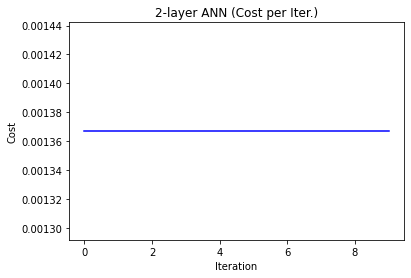

Divider:  0.9933069692973424 

             Pred. Not Churned  Pred. Churned
Not Churned                564           1031
Churned                    133            272 

Accuracy score: 0.418 (Correct: 836, Incorrect: 1164)

Total Churned: 405, Not Churned: 1595


In [240]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

plt.plot(np.arange(len(costs)), costs, color='blue')
plt.title('2-layer ANN (Cost per Iter.)')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

y_pred = model.predict(x_test).flatten()
y_pred_divider = (np.min(y_pred) + np.max(y_pred)) / 2

print('Divider: ', y_pred_divider, '\n')

y_pred = y_pred > y_pred_divider

cm = confusion_matrix(y_test, y_pred)

print(pd.DataFrame(cm, columns=['Pred. Not Churned', 'Pred. Churned'], index=['Not Churned', 'Churned']), '\n')
print(f'Accuracy score: {accuracy_score(y_test, y_pred)} (Correct: {cm[0][0] + cm[1][1]}, Incorrect: {cm[0][1] + cm[1][0]})\n')
print(f'Total Churned: {len(list(filter(lambda a: a == 1, y_test)))}, Not Churned: {len(list(filter(lambda a: a == 0, y_test)))}')
